In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style="whitegrid")

In [6]:
# Load historical trader data
historical_df = pd.read_csv("historical_data.csv", low_memory=False)

# Load fear & greed index data
sentiment_df = pd.read_csv("fear_greed_index.csv")

In [8]:
# First look at the datasets
sentiment_df.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [9]:
# First look at the datasets
historical_df.head()



,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,986.87,7872.16,BUY,02-12-2024 22:50,0.00,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.35,895000000000000.00,1730000000000.00
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,16.00,127.68,BUY,02-12-2024 22:50,986.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.01,443000000000000.00,1730000000000.00
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,144.09,1150.63,BUY,02-12-2024 22:50,1002.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,660000000000000.00,1730000000000.00
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,142.98,1142.04,BUY,02-12-2024 22:50,1146.56,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,1080000000000000.00,1730000000000.00
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,8.73,69.75,BUY,02-12-2024 22:50,1289.49,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.00,1050000000000000.00,1730000000000.00


In [10]:

print("Historical Data Shape:", historical_df.shape)
print("Sentiment Data Shape:", sentiment_df.shape)


Historical Data Shape: (211224, 16)
Sentiment Data Shape: (2644, 4)


In [11]:
# Column names check
sentiment_df.columns


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

In [12]:
historical_df.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [15]:
# checking null values
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [14]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [18]:
# Convert Time column to datetime
historical_df['Timestamp IST'] = pd.to_datetime(
    historical_df['Timestamp IST'],
    errors='coerce'
)

# Extract date for merging
historical_df['trade_date'] = historical_df['Timestamp IST'].dt.date

In [19]:
# Convert sentiment date
sentiment_df['date'] = pd.to_datetime(
    sentiment_df['date'],
    errors='coerce'
).dt.date


In [20]:
# Closed PnL should be numeric
historical_df['Closed PnL'] = pd.to_numeric(
    historical_df['Closed PnL'],
    errors='coerce'
)


In [21]:
# Check missing values
historical_df['Closed PnL'].isna().sum()


np.int64(0)

In [22]:
# Drop rows where PnL is missing (cannot analyze those trades)
historical_df = historical_df.dropna(subset=['Closed PnL'])


In [23]:
# Check duplicates
historical_df.duplicated().sum()


np.int64(0)

In [24]:
# Drop duplicates if any
historical_df = historical_df.drop_duplicates()


In [25]:
# Select only required sentiment columns
sentiment_clean = sentiment_df[['date', 'classification', 'value']]


In [26]:
# Merge on date
merged_df = pd.merge(
    historical_df,
    sentiment_clean,
    left_on='trade_date',
    right_on='date',
    how='inner'
)


In [27]:
# Verify merge success
merged_df.head()
merged_df.shape


(35864, 20)

In [28]:
#feature engineering
# Profit or Loss flag
merged_df['profit_flag'] = np.where(
    merged_df['Closed PnL'] > 0, 'Profit', 'Loss'
)


In [29]:
# Absolute PnL (risk magnitude)
merged_df['abs_pnl'] = merged_df['Closed PnL'].abs()


In [30]:
# eda
trade_count = merged_df.groupby('classification').size()
trade_count


,0
classification,
Extreme Fear,2326
Extreme Greed,5621
Fear,13869
Greed,11292
Neutral,2756


In [31]:
#Average PnL by Market Sentiment
avg_pnl = merged_df.groupby('classification')['Closed PnL'].mean()
avg_pnl


,Closed PnL
classification,
Extreme Fear,1.89
Extreme Greed,205.82
Fear,128.29
Greed,53.99
Neutral,27.09


In [33]:
total_pnl = merged_df.groupby('classification')['Closed PnL'].sum()
total_pnl


,Closed PnL
classification,
Extreme Fear,4399.94
Extreme Greed,1156893.68
Fear,1779225.58
Greed,609632.53
Neutral,74656.74


In [34]:
#Profit vs Loss Distribution
pd.crosstab(
    merged_df['classification'],
    merged_df['profit_flag'],
    normalize='index'
) * 100


profit_flag,Loss,Profit
classification,,
Extreme Fear,70.72,29.28
Extreme Greed,44.67,55.33
Fear,61.82,38.18
Greed,56.43,43.57
Neutral,50.51,49.49


** IN Fear market  loss percentage is greater than Greed market.**

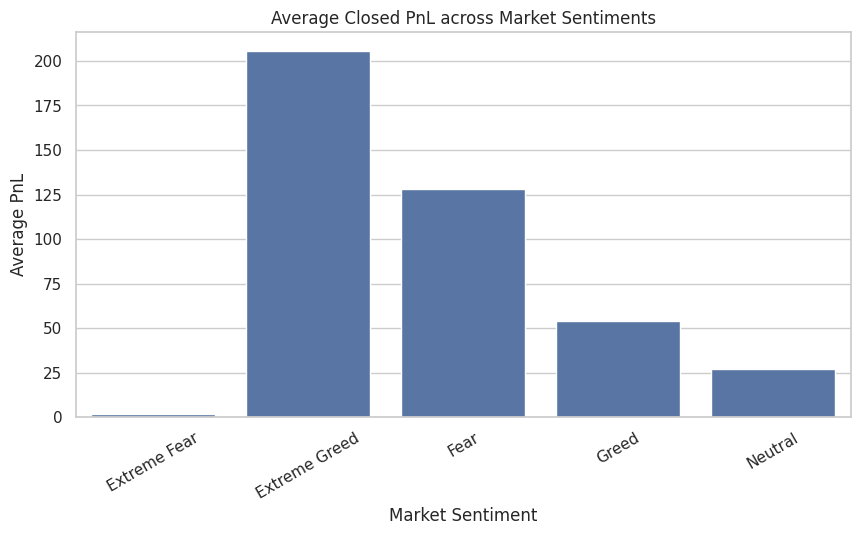

In [35]:
# Bar Plot – Average PnL
plt.figure(figsize=(10,5))
sns.barplot(
    x=avg_pnl.index,
    y=avg_pnl.values
)
plt.title("Average Closed PnL across Market Sentiments")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.xticks(rotation=30)
plt.show()


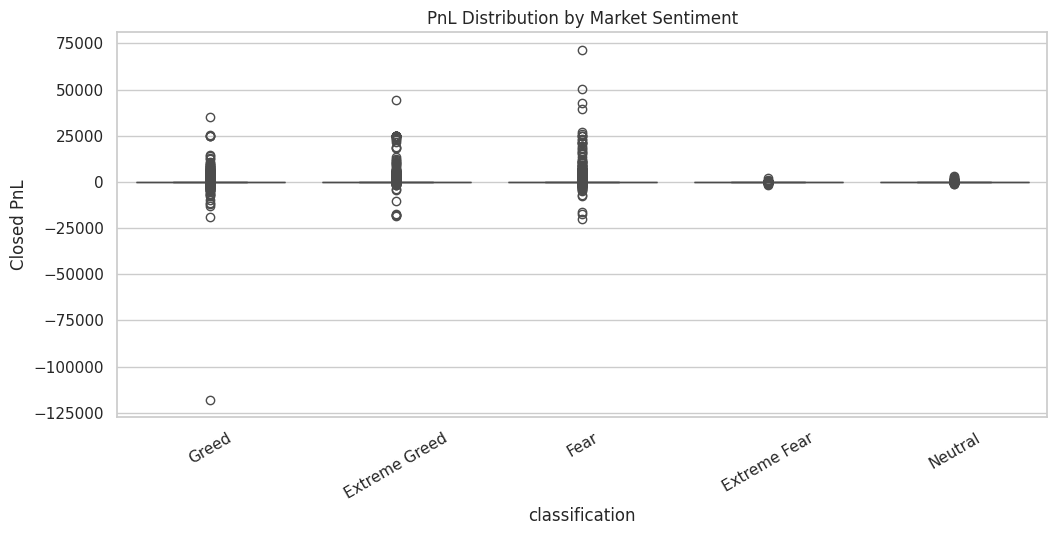

In [36]:
#Box Plot- Risk Comparison
plt.figure(figsize=(12,5))
sns.boxplot(
    x='classification',
    y='Closed PnL',
    data=merged_df
)
plt.title("PnL Distribution by Market Sentiment")
plt.xticks(rotation=30)
plt.show()


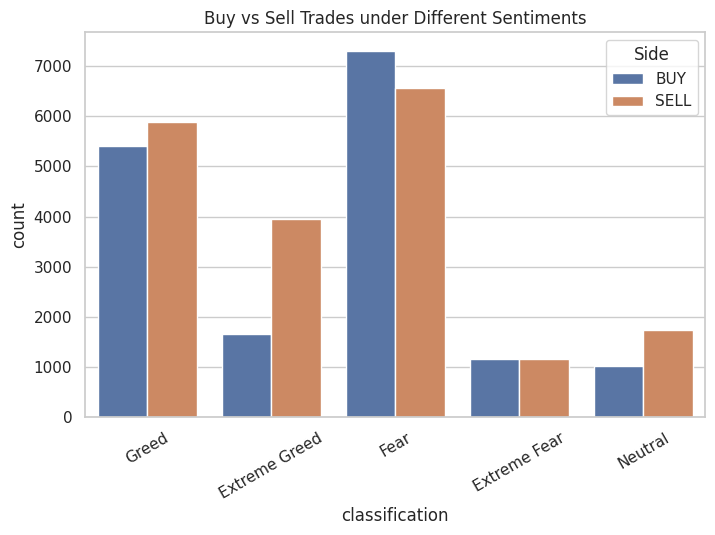

In [37]:
#BUY VS SELL BEHAVIOUR
plt.figure(figsize=(8,5))
sns.countplot(
    x='classification',
    hue='Side',
    data=merged_df
)
plt.title("Buy vs Sell Trades under Different Sentiments")
plt.xticks(rotation=30)
plt.show()


# Conclusion:
This analysis shows that trader performance is strongly affected by overall market sentiment. Using sentiment indicators like the Fear & Greed Index can help traders make better decisions about position size, leverage, and risk management in volatile crypto markets.

